In [2]:
import re
import json
import bz2
import pickle
import zstandard
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [ ]:
def compress_size(bytefile):
    return len(zstandard.compress(bytefile))

def ncd(obj1, obj2):
    len1 = compress_size(obj1)
    len2 = compress_size(obj2)
    concat_len = len(zstandard.compress(obj1+obj2))
    return (concat_len-min(len1, len2))/max(len1, len2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# P10
### ¿Cual es el nombre del usuario que hizo más reviews en el estado de California?

In [3]:
users = pd.read_csv("/content/drive/MyDrive/Orga Datos/TP1/Dataset/user.csv")
businesses = pd.read_csv("/content/drive/MyDrive/Orga Datos/TP1/Dataset/business.csv")
reviews = pd.read_csv("/content/drive/MyDrive/Orga Datos/TP1/Dataset/review.csv")

In [ ]:
newUsers = users[["user_id", "name", "review_count"]]
newBusinesses = businesses[["business_id", "state"]]
newReviews = reviews[["review_id", "user_id", "business_id", "text"]]
newUsers.dropna(inplace=True)
newBusinesses.dropna(inplace=True)
newReviews.dropna(inplace=True)

In [32]:
# Primero quiero buscar los locales que son del estado de California
californiaBusinesses = newBusinesses.loc[newBusinesses["state"].str.contains("CA")]
californiaBusinesses = californiaBusinesses.reset_index()

In [ ]:
# Me quedo con las reviews que son de los locales de California
californiaReviews = californiaBusinesses.merge(newReviews, left_on='business_id', right_on='business_id')
californiaReviews.set_index('index')
californiaReviews = californiaReviews.drop('index', axis=1)

In [ ]:
usersReviews = californiaReviews.groupby("user_id").agg({"review_id": 'count'})
usersWithMoreReviews = usersReviews.nlargest(5,'review_id')
usersWithMoreReviewsCA = usersWithMoreReviews.rename(columns={"review_id": "review_count_CA"})

In [ ]:
californiaUsers = usersWithMoreReviewsCA.merge(newUsers, left_on="user_id", right_on="user_id")

In [44]:
californiaUser = californiaUsers.loc[0]
californiaUserName = californiaUser[["name"]].to_list()
print("The user with more reviews is:", californiaUserName[0])

The user with more reviews is: Eric


# V1 (Heatmap)
### Correlación entre votos useful, funny y cool

In [53]:
votes = reviews[["useful", "funny", "cool"]]
corrReviews = votes.corr()

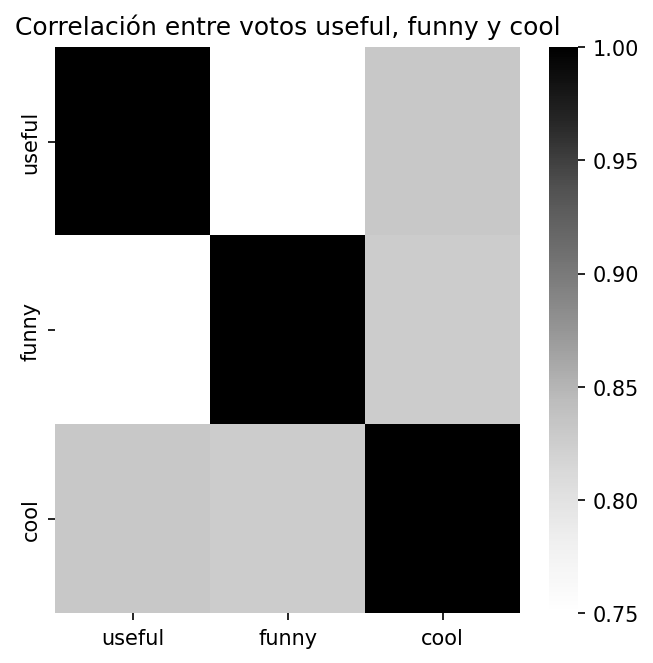

In [49]:
plt.figure(figsize=(5,5), dpi=150)
sns.heatmap(corrReviews, cmap='Greys', vmin=0.75, vmax=1)
plt.title("Correlación entre votos useful, funny y cool")
plt.show()

## V4 (Heatmap)
### Correlación de abrir por días de la semana

In [ ]:
businessesHours = businesses[["hours"]]
businessesHours.dropna(inplace=True)

In [19]:
datesList = []
for item in businessesHours["hours"]: datesList.append(json.loads(item.replace("'", '"')))

for date in datesList: 
    for key, value in date.items(): date[key] = 1

dfDates = pd.DataFrame(datesList)

In [20]:
dfDates = dfDates.fillna(0)
dfDates.rename(columns={"Monday": "Lunes", "Tuesday": "Martes", "Wednesday": "Miercoles", "Thursday": "Jueves", "Friday": "Viernes", "Saturday": "Sabado", "Sunday": "Domingo"}, inplace=True)
corrDates = dfDates.corr()

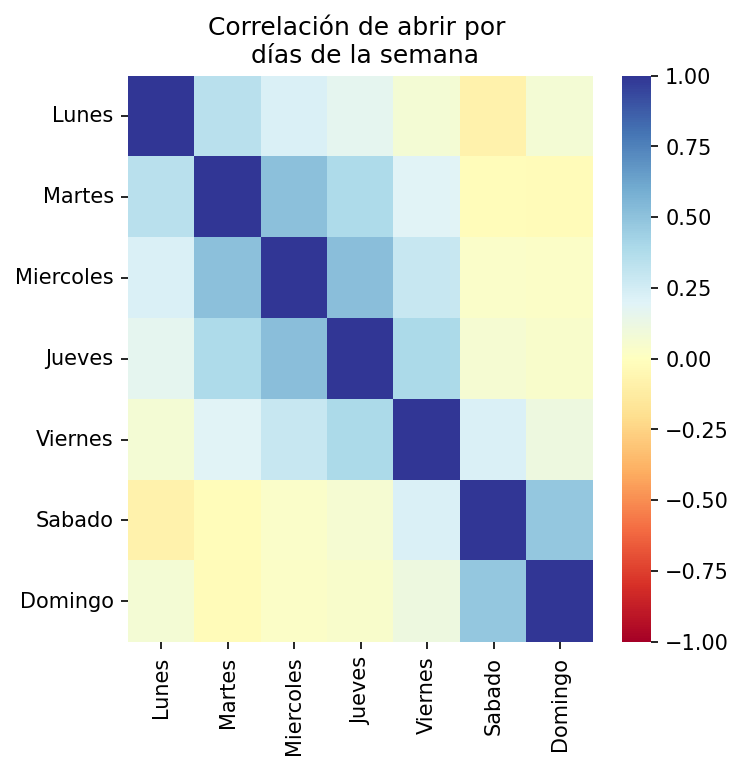

In [21]:
plt.figure(figsize=(5,5), dpi=150)
sns.heatmap(corrDates, cmap='RdYlBu', vmin=-1, vmax=1)
plt.title("Correlación de abrir por \n días de la semana")
plt.show()

# N3
### La 3-upla de palabras (no letras) más común en los comentarios de los tips. De ser necesario, se puede utilizar un sample y no la totalidad de datos.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [34]:
tips = pd.read_csv("/content/drive/MyDrive/Orga Datos/TP1/Dataset/tip.csv")

In [ ]:
#tips.dropna(inplace=True)
tipsText = tips[["text"]]
tipsText.dropna(inplace=True)
# Puedo usar un sample del dataset
#tipsText = tipsText.sample(10000)
#tipsTextList = tipsText['text'].to_list()
#tipsTextList = tipsText[:100000]["text"].to_list()
tipsTextList = tipsText[:10000]["text"].to_list()

In [42]:
stopwords = set(stopwords.words('english'))

In [43]:
count_vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(3,3), analyzer="word")

In [44]:
tf_matrix = count_vectorizer.fit_transform(tipsTextList)

In [45]:
# Frecuencias de la suma
sumaFrecuenciaMatriz = sum(tf_matrix).data

In [46]:
featureNames = count_vectorizer.get_feature_names_out()

In [47]:
df = pd.DataFrame(sumaFrecuenciaMatriz, index=featureNames)
df = df.rename(columns={0: 'sum_frecuencia'})

In [48]:
threeUple = df.nlargest(1, columns="sum_frecuencia").index
threeUpleWords = threeUple[0]
threeUpleWords

'lots meats including'

# C3
### Utilizando la declaración universal de los derechos humanos en español y portugues y utilizando la distancia normalizada de compresión, encuentre una review en español y otra en portugues (puede tomar un sample siempre y cuando sea capaz de encontrar eso en el sample).

In [53]:
dHEsp = """
Declaración Universal de Derechos Humanos
Adoptada y proclamada por la Asamblea General en su resolución 217 A (III), de
10 de diciembre de 1948 Preámbulo
Considerando que la libertad, la justicia y la paz en el mundo tienen por base el reconocimiento de la dignidad intrínseca y de los derechos iguales e inalienables de todos los miembros de la familia humana,
Considerando que el desconocimiento y el menosprecio de los derechos humanos han originado actos de barbarie ultrajantes para la conciencia de la humanidad; y que se ha proclamado, como la aspiración más elevada del hombre, el advenimiento de un mundo en que los seres humanos, liberados del temor y de la miseria, disfruten de la libertad de palabra y de la libertad de creencias,
Considerando esencial que los derechos humanos sean protegidos por un régimen de Derecho, a fin de que el hombre no se vea compelido al supremo recurso de la rebelión contra la tiranía y la opresión,
Considerando también esencial promover el desarrollo de relaciones amistosas entre las naciones,
Considerando que los pueblos de las Naciones Unidas han reafirmado en la Carta su fe en los derechos fundamentales del hombre, en la dignidad y el valor de la persona humana y en la igualdad de derechos de hombres y mujeres; y se han declarado resueltos a promover el progreso social y a elevar el nivel de vida dentro de un concepto más amplio de la libertad,
Considerando que los Estados Miembros se han comprometido a asegurar, en cooperación con la Organización de las Naciones Unidas, el respeto universal y efectivo a los derechos y libertades fundamentales del hombre, y
Considerando que una concepción común de estos derechos y libertades es de la mayor importancia para el pleno cumplimiento de dicho compromiso,

La Asamblea General
Proclama la presente Declaración Universal de Derechos Humanos como ideal común por el que todos los pueblos y naciones deben esforzarse, a fin de que tanto los individuos como las instituciones, inspirándose constantemente en ella, promuevan, mediante la enseñanza y la educación, el respeto a estos derechos y libertades, y aseguren, por medidas progresivas de carácter nacional e internacional, su reconocimiento y aplicación universales y efectivos, tanto entre los pueblos de los Estados Miembros como entre los de los territorios colocados bajo su jurisdicción.
Artículo 1
Todos los seres humanos nacen libres e iguales en dignidad y derechos y, dotados como están de razón y conciencia, deben comportarse fraternalmente los unos con los otros.
Artículo 2
Toda persona tiene los derechos y libertades proclamados en esta Declaración, sin distinción alguna de raza, color, sexo, idioma, religión, opinión política o de cualquier otra índole, origen nacional o social, posición económica, nacimiento o cualquier otra condición.
Además, no se hará distinción alguna fundada en la condición política, jurídica o internacional del país o territorio de cuya jurisdicción dependa una persona, tanto si se trata de un país independiente, como de un territorio bajo administración fiduciaria, no autónomo o sometido a cualquier otra limitación de soberanía.
Artículo 3
Todo individuo tiene derecho a la vida, a la libertad y a la seguridad de su persona.

Artículo 4
Nadie estará sometido a esclavitud ni a servidumbre; la esclavitud y la trata de
esclavos están prohibidas en todas sus formas. Artículo 5
Nadie será sometido a torturas ni a penas o tratos crueles, inhumanos o degradantes.
Artículo 6
Todo ser humano tiene derecho, en todas partes, al reconocimiento de su
personalidad jurídica. Artículo 7
Todos son iguales ante la ley y tienen, sin distinción, derecho a igual protección de la ley. Todos tienen derecho a igual protección contra toda discriminación que infrinja esta Declaración y contra toda provocación a tal discriminación.
Artículo 8
Toda persona tiene derecho a un recurso efectivo, ante los tribunales nacionales competentes, que la ampare contra actos que violen sus derechos fundamentales reconocidos por la constitución o por la ley.
Artículo 9
Nadie podrá ser arbitrariamente detenido, preso ni desterrado. Artículo 10
Toda persona tiene derecho, en condiciones de plena igualdad, a ser oída públicamente y con justicia por un tribunal independiente e imparcial, para la

determinación de sus derechos y obligaciones o para el examen de cualquier acusación contra ella en materia penal.
Artículo 11
1. Todapersonaacusadadedelitotienederechoaquesepresumasu inocencia mientras no se pruebe su culpabilidad, conforme a la ley y en juicio público en el que se le hayan asegurado todas las garantías necesarias para su defensa.
2. Nadie será condenado por actos u omisiones que en el momento de cometerse no fueron delictivos según el Derecho nacional o internacional. Tampoco se impondrá pena más grave que la aplicable en el momento de la comisión del delito.
Artículo 12
Nadie será objeto de injerencias arbitrarias en su vida privada, su familia, su domicilio o su correspondencia, ni de ataques a su honra o a su reputación. Toda persona tiene derecho a la protección de la ley contra tales injerencias o ataques.
Artículo 13
1. Todapersonatienederechoacircularlibrementeyaelegirsuresidencia en el territorio de un Estado.
2. Todapersonatienederechoasalirdecualquierpaís,inclusoelpropio,y a regresar a su país.
Artículo 14
1. Encasodepersecución,todapersonatienederechoabuscarasilo,ya disfrutar de él, en cualquier país.

2. Estederechonopodráserinvocadocontraunaacciónjudicialrealmente originada por delitos comunes o por actos opuestos a los propósitos y principios de las Naciones Unidas.
Artículo 15
1. Todapersonatienederechoaunanacionalidad.
2. Anadieseprivaráarbitrariamentedesunacionalidadnidelderechoa
cambiar de nacionalidad.
Artículo 16
1. Loshombresylasmujeres,apartirdelaedadnúbil,tienenderecho,sin restricción alguna por motivos de raza, nacionalidad o religión, a casarse y fundar una familia; y disfrutarán de iguales derechos en cuanto al matrimonio, durante el matrimonio y en caso de disolución del matrimonio.
2. Sólomediantelibreyplenoconsentimientodelosfuturosesposospodrá contraerse el matrimonio.
3. Lafamiliaeselelementonaturalyfundamentaldelasociedadytiene derecho a la protección de la sociedad y del Estado.
Artículo 17
1. Todapersonatienederechoalapropiedad,individualycolectivamente.
2. Nadieseráprivadoarbitrariamentedesupropiedad. Artículo 18
Toda persona tiene derecho a la libertad de pensamiento, de conciencia y de religión; este derecho incluye la libertad de cambiar de religión o de creencia, así como la libertad de manifestar su religión o su creencia, individual y colectivamente, tanto en público como en privado, por la enseñanza, la práctica, el culto y la observancia.

Artículo 19
Todo individuo tiene derecho a la libertad de opinión y de expresión; este derecho incluye el no ser molestado a causa de sus opiniones, el de investigar y recibir informaciones y opiniones, y el de difundirlas, sin limitación de fronteras, por cualquier medio de expresión.
Artículo 20
1. Todapersonatienederechoalalibertaddereuniónydeasociación pacíficas.
2. Nadiepodráserobligadoaperteneceraunaasociación.
Artículo 21
1. Todapersonatienederechoaparticiparenelgobiernodesupaís, directamente o por medio de representantes libremente escogidos.
2. Todapersonatieneelderechodeacceso,encondicionesdeigualdad,a las funciones públicas de su país.
3. Lavoluntaddelpuebloeslabasedelaautoridaddelpoderpúblico;esta voluntad se expresará mediante elecciones auténticas que habrán de celebrarse periódicamente, por sufragio universal e igual y por voto secreto u otro procedimiento equivalente que garantice la libertad del voto.
Artículo 22
Toda persona, como miembro de la sociedad, tiene derecho a la seguridad social, y a obtener, mediante el esfuerzo nacional y la cooperación internacional, habida cuenta de la organización y los recursos de cada Estado, la satisfacción de los derechos económicos, sociales y culturales, indispensables a su dignidad y al libre desarrollo de su personalidad.

Artículo 23
1. Todapersonatienederechoaltrabajo,alalibreeleccióndesutrabajo,a condiciones equitativas y satisfactorias de trabajo y a la protección contra el desempleo.
2. Todapersonatienederecho,sindiscriminaciónalguna,aigualsalariopor trabajo igual.
3. Todapersonaquetrabajatienederechoaunaremuneraciónequitativay satisfactoria, que le asegure, así como a su familia, una existencia conforme a la dignidad humana y que será completada, en caso necesario, por cualesquiera otros medios de protección social.
4. Todapersonatienederechoafundarsindicatosyasindicarseparala defensa de sus intereses.
Artículo 24
Toda persona tiene derecho al descanso, al disfrute del tiempo libre, a una limitación razonable de la duración del trabajo y a vacaciones periódicas pagadas.
Artículo 25
1. Todapersonatienederechoaunniveldevidaadecuadoqueleasegure, así como a su familia, la salud y el bienestar, y en especial la alimentación, el vestido, la vivienda, la asistencia médica y los servicios sociales necesarios; tiene asimismo derecho a los seguros en caso de desempleo, enfermedad, invalidez, viudez, vejez y otros casos de pérdida de sus medios de subsistencia por circunstancias independientes de su voluntad.
2. Lamaternidadylainfanciatienenderechoacuidadosyasistencia especiales. Todos los niños, nacidos de matrimonio o fuera de matrimonio, tienen derecho a igual protección social.

Artículo 26
1. Toda persona tiene derecho a la educación. La educación debe ser gratuita, al menos en lo concerniente a la instrucción elemental y fundamental. La instrucción elemental será obligatoria. La instrucción técnica y profesional habrá de ser generalizada; el acceso a los estudios superiores será igual para todos, en función de los méritos respectivos.
2. Laeducacióntendráporobjetoelplenodesarrollodelapersonalidad humana y el fortalecimiento del respeto a los derechos humanos y a las libertades fundamentales; favorecerá la comprensión, la tolerancia y la amistad entre todas las naciones y todos los grupos étnicos o religiosos; y promoverá el desarrollo de las actividades de las Naciones Unidas para el mantenimiento de la paz.
3. Lospadrestendránderechopreferenteaescogereltipodeeducación que habrá de darse a sus hijos.
Artículo 27
1. Todapersonatienederechoatomarpartelibrementeenlavidacultural de la comunidad, a gozar de las artes y a participar en el progreso científico y en los beneficios que de él resulten.
2. Todapersonatienederechoalaproteccióndelosinteresesmoralesy materiales que le correspondan por razón de las producciones científicas, literarias o artísticas de que sea autora.
Artículo 28
Toda persona tiene derecho a que se establezca un orden social e internacional en el que los derechos y libertades proclamados en esta Declaración se hagan plenamente efectivos.
Artículo 29

1. Todapersonatienedeberesrespectoalacomunidad,puestoquesóloen ella puede desarrollar libre y plenamente su personalidad.
2. Enelejerciciodesusderechosyeneldisfrutedesuslibertades,toda persona estará solamente sujeta a las limitaciones establecidas por la ley con el único fin de asegurar el reconocimiento y el respeto de los derechos y libertades de los demás, y de satisfacer las justas exigencias de la moral, del orden público y del bienestar general en una sociedad democrática.
3. Estosderechosylibertadesnopodránenningúncasoserejercidosen oposición a los propósitos y principios de las Naciones Unidas.
Artículo 30
Nada en la presente Declaración podrá interpretarse en el sentido de que confiere derecho alguno al Estado, a un grupo o a una persona, para emprender y desarrollar actividades o realizar actos tendientes a la supresión de cualquiera de los derechos y libertades proclamados en esta Declaración.
"""

In [54]:
dHPort = """
Declaração Universal dos Direitos Humanos
*tradução oficial, UNITED NATIONS HIGH COMMISSIONER FOR HUMAN RIGHTS
Preâmbulo
Considerando que o reconhecimento da dignidade inerente a todos os membros da família humana e dos seus direitos iguais e inalienáveis constitui o fundamento da liberdade, da justiça e da paz no mundo;
Considerando que o desconhecimento e o desprezo dos direitos do Homem conduziram a atos de barbárie que revoltam a consciência da Humanidade e que o advento de um mundo em que os seres humanos sejam livres de falar e de crer, libertos do terror e da miséria, foi proclamado como a mais alta inspiração do Homem;
Considerando que é essencial a proteção dos direitos do Homem através de um regime de direito, para que o Homem não seja compelido, em supremo recurso, à revolta contra a tirania e a opressão;
Considerando que é essencial encorajar o desenvolvimento de relações amistosas entre as nações;
Considerando que, na Carta, os povos das Nações Unidas proclamam, de novo, a sua fé nos direitos fundamentais do Homem, na dignidade e no valor da pessoa humana, na igualdade de direitos dos homens e das mulheres e se declaram resolvidos a favorecer o progresso social e a instaurar melhores condições de vida dentro de uma liberdade mais ampla;
Considerando que os Estados membros se comprometeram a promover, em cooperação com a Organização das Nações Unidas, o respeito universal e efetivo dos direitos do Homem e das liberdades fundamentais;
Considerando que uma concepção comum destes direitos e liberdades é da mais alta importância para dar plena satisfação a tal compromisso:
A Assembléia Geral proclama a presente Declaração Universal dos Direitos Humanos como ideal comum a atingir por todos os povos e todas as nações, a fim de que todos os indivíduos e todos os órgãos da sociedade, tendo-a constantemente no espírito, se esforcem, pelo ensino e pela educação, por desenvolver o respeito desses direitos e liberdades e por promover, por medidas progressivas de ordem nacional e internacional, o seu reconhecimento e a sua aplicação universais e efetivos tanto entre as populações dos próprios Estados membros como entre as dos territórios colocados sob a sua jurisdição.
Artigo 1°
Todos os seres humanos nascem livres e iguais em dignidade e em direitos. Dotados de razão e de consciência, devem agir uns para com os outros em espírito de fraternidade.
Artigo 2°
Todos os seres humanos podem invocar os direitos e as liberdades proclamados na presente Declaração, sem distinção alguma, nomeadamente de raça, de cor, de sexo, de língua, de religião, de opinião política ou outra, de origem nacional ou social, de fortuna, de nascimento ou de qualquer outra situação. Além disso, não será feita nenhuma distinção fundada no estatuto
 
político, jurídico ou internacional do país ou do território da naturalidade da pessoa, seja esse país ou território independente, sob tutela, autônomo ou sujeito a alguma limitação de soberania.
Artigo 3°
Artigo 4°
Ninguém será mantido em escravatura ou em servidão; a escravatura e o trato dos escravos, sob todas as formas, são proibidos.
Artigo 5°
Ninguém será submetido a tortura nem a penas ou tratamentos cruéis, desumanos ou degradantes.
Artigo 6°
Todos os indivíduos têm direito ao reconhecimento, em todos os lugares, da sua personalidade jurídica.
Artigo 7°
Todos são iguais perante a lei e, sem distinção, têm direito a igual proteção da lei. Todos têm direito a proteção igual contra qualquer discriminação que viole a presente Declaração e contra qualquer incitamento a tal discriminação.
Artigo 8°
Toda a pessoa direito a recurso efetivo para as jurisdições nacionais competentes contra os atos que violem os direitos fundamentais reconhecidos pela Constituição ou pela lei.
Artigo 9°
Artigo 10°
Toda a pessoa tem direito, em plena igualdade, a que a sua causa seja eqüitativa e publicamente julgada por um tribunal independente e imparcial que decida dos seus direitos e obrigações ou das razões de qualquer acusação em matéria penal que contra ela seja deduzida.
Artigo 11°
1. Toda a pessoa acusada de um ato delituoso presume-se inocente até que a sua culpabilidade fique legalmente provada no decurso de um processo público em que todas as garantias necessárias de defesa lhe sejam asseguradas.
2. Ninguém será condenado por ações ou omissões que, no momento da sua prática, não constituíam ato delituoso à face do direito interno ou internacional. Do mesmo modo, não será infligida pena mais grave do que a que era aplicável no momento em que o acto delituoso foi cometido.
Todo indivíduo tem direito à vida, à liberdade e à segurança pessoal.
Ninguém pode ser arbitrariamente preso, detido ou exilado.

Artigo 12°
Ninguém sofrerá intromissões arbitrárias na sua vida privada, na sua família, no seu domicílio ou na sua correspondência, nem ataques à sua honra e reputação. Contra tais intromissões ou ataques toda a pessoa tem direito a proteção da lei.
Artigo 13°
1. Toda a pessoa tem o direito de livremente circular e escolher a sua residência no interior de um Estado.
2. Toda a pessoa tem o direito de abandonar o país em que se encontra, incluindo o seu, e o direito de regressar ao seu país.
Artigo 14°
1. Toda a pessoa sujeita a perseguição tem o direito de procurar e de beneficiar de asilo em outros países.
2. Este direito não pode, porém, ser invocado no caso de processo realmente existente por crime de direito comum ou por atividades contrárias aos fins e aos princípios das Nações Unidas.
Artigo 15°
1. Todo o indivíduo tem direito a ter uma nacionalidade.
2. Ninguém pode ser arbitrariamente privado da sua nacionalidade nem do direito de mudar
de nacionalidade.
Artigo 16°
1. A partir da idade núbil, o homem e a mulher têm o direito de casar e de constituir família, sem restrição alguma de raça, nacionalidade ou religião. Durante o casamento e na altura da sua dissolução, ambos têm direitos iguais.
2. O casamento não pode ser celebrado sem o livre e pleno consentimento dos futuros esposos.
3. A família é o elemento natural e fundamental da sociedade e tem direito à proteção desta e do Estado.
Artigo 17°
1. Toda a pessoa, individual ou coletiva, tem direito à propriedade.
2. Ninguém pode ser arbitrariamente privado da sua propriedade.
Artigo 18°
Toda a pessoa tem direito à liberdade de pensamento, de consciência e de religião; este direito implica a liberdade de mudar de religião ou de convicção, assim como a liberdade de manifestar a religião ou convicção, sozinho ou em comum, tanto em público como em privado, pelo ensino, pela prática, pelo culto e pelos ritos.
Artigo 19°
Todo o indivíduo tem direito à liberdade de opinião e de expressão, o que implica o direito de não ser inquietado pelas suas opiniões e o de procurar, receber e difundir, sem consideração de fronteiras, informações e idéias por qualquer meio de expressão.

Artigo 20°
1. Toda a pessoa tem direito à liberdade de reunião e de associação pacíficas.
2. Ninguém pode ser obrigado a fazer parte de uma associação.
Artigo 21°
1. Toda a pessoa tem o direito de tomar parte na direção dos negócios, públicos do seu país, quer diretamente, quer por intermédio de representantes livremente escolhidos.
2. Toda a pessoa tem direito de acesso, em condições de igualdade, às funções públicas do seu país.
3. A vontade do povo é o fundamento da autoridade dos poderes públicos: e deve exprimir-se através de eleições honestas a realizar periodicamente por sufrágio universal e igual, com voto secreto ou segundo processo equivalente que salvaguarde a liberdade de voto.
Artigo 22°
Toda a pessoa, como membro da sociedade, tem direito à segurança social; e pode legitimamente exigir a satisfação dos direitos econômicos, sociais e culturais indispensáveis, graças ao esforço nacional e à cooperação internacional, de harmonia com a organização e os recursos de cada país.
Artigo 23°
1. Toda a pessoa tem direito ao trabalho, à livre escolha do trabalho, a condições eqüitativas e satisfatórias de trabalho e à proteção contra o desemprego.
2. Todos têm direito, sem discriminação alguma, a salário igual por trabalho igual.
3. Quem trabalha tem direito a uma remuneração eqüitativa e satisfatória, que lhe permita e à sua família uma existência conforme com a dignidade humana, e completada, se possível,
por todos os outros meios de proteção social.
4. Toda a pessoa tem o direito de fundar com outras pessoas sindicatos e de se filiar em
sindicatos para defesa dos seus interesses.
Artigo 24°
Toda a pessoa tem direito ao repouso e aos lazeres, especialmente, a uma limitação razoável da duração do trabalho e as férias periódicas pagas.
Artigo 25°
1. Toda a pessoa tem direito a um nível de vida suficiente para lhe assegurar e à sua família a saúde e o bem-estar, principalmente quanto à alimentação, ao vestuário, ao alojamento, à assistência médica e ainda quanto aos serviços sociais necessários, e tem direito à segurança no desemprego, na doença, na invalidez, na viuvez, na velhice ou noutros casos de perda de meios de subsistência por circunstâncias independentes da sua vontade.
2. A maternidade e a infância têm direito a ajuda e a assistência especiais. Todas as crianças, nascidas dentro ou fora do matrimônio, gozam da mesma proteção social.
Artigo 26°
1. Toda a pessoa tem direito à educação. A educação deve ser gratuita, pelo menos a correspondente ao ensino elementar fundamental. O ensino elementar é obrigatório. O ensino técnico e profissional dever ser generalizado; o acesso aos estudos superiores deve estar aberto a todos em plena igualdade, em função do seu mérito.

2. A educação deve visar à plena expansão da personalidade humana e ao reforço dos direitos do Homem e das liberdades fundamentais e deve favorecer a compreensão, a tolerância e a amizade entre todas as nações e todos os grupos raciais ou religiosos, bem como o desenvolvimento das atividades das Nações Unidas para a manutenção da paz.
3. Aos pais pertence a prioridade do direito de escolher o gênero de educação a dar aos filhos.
Artigo 27°
1. Toda a pessoa tem o direito de tomar parte livremente na vida cultural da comunidade, de fruir as artes e de participar no progresso científico e nos benefícios que deste resultam.
2. Todos têm direito à proteção dos interesses morais e materiais ligados a qualquer
produção científica, literária ou artística da sua autoria.
Artigo 28°
Toda a pessoa tem direito a que reine, no plano social e no plano internacional, uma ordem capaz de tornar plenamente efetivos os direitos e as liberdades enunciadas na presente Declaração.
Artigo 29°
1. O indivíduo tem deveres para com a comunidade, fora da qual não é possível o livre e pleno desenvolvimento da sua personalidade.
No exercício deste direito e no gozo destas liberdades ninguém está sujeito senão às limitações estabelecidas pela lei com vista exclusivamente a promover o reconhecimento e o respeito dos direitos e
2. liberdades dos outros e a fim de satisfazer as justas exigências da moral, da ordem pública e do bem-estar numa sociedade democrática.
3. Em caso algum estes direitos e liberdades poderão ser exercidos contrariamente e aos fins e aos princípios das Nações Unidas.
Artigo 30°
Nenhuma disposição da presente Declaração pode ser interpretada de maneira a envolver para qualquer Estado, agrupamento ou indivíduo o direito de se entregar a alguma atividade ou de praticar algum ato destinado a destruir os direitos e liberdades aqui enunciados.
"""

In [56]:
dHEspEncoded = dHEsp.encode()
dHPortEncoded = dHPort.encode()

In [ ]:
reviewsTexts = reviews[["text"]]
reviewsTexts.dropna(inplace=True)
# Chequar filtrado
#reviewsTexts = reviewsTexts.dropna()
reviewsTextsSample = reviewsTexts.sample(200000, random_state = 24)
reviewsTextsList = reviewsTextsSample["text"].to_list()

In [ ]:
ncDistSp = []
ncDistPo = []
for review in tqdm(reviewsTextsList):
  ncDistSp.append(ncd(review.encode(), dHEspEncoded))
  ncDistPo.append(ncd(review.encode(), dHPortEncoded))

In [62]:
reviewsTextsSample['ncdSp'] = ncDistSp
reviewsTextsSample['ncdPo'] = ncDistPo

In [ ]:
spanishReview = reviewsTextsSample.nsmallest(1, columns='ncdSp')['text'].to_list()[0]
print('Spanish Review:\n',spanishReview)

In [ ]:
portugueseReview = reviewsTextsSample.nsmallest(1, columns='ncdPo')['text'].to_list()[0]
print('Portuguese Review:\n',portugueseReview)

# C7 
### Para aquellos negocios que tengan más de 5 sucursales y su distribución probabilística de sucursales por ciudad. Calcule la divergencia de Kullback Leibler entre todos los negocios:
### ¿Por qué dan casi todas infinito? Para corregirlo recalcule todo sumando 1*10^-10 en el denominador del logaritmo.
### ¿A qué negocios y en qué sentido corresponde la menor divergencia de Kullback Leibler? (recordar que la divergencia es dirigida)
### Cuál es el negocio con mejor divergencia de Kullback-Leibler respecto de Burger King? ¿Y de McDonalds?

In [ ]:
businessesPerCity = businesses[["name", 'city']]
businessesPerCity.dropna(inplace=True)
amountOfStoresPerCity = businessesPerCity.groupby("name").agg({"city": "count"})

In [67]:
# Me quedo con los negocios que tienen mas de cinco sucursales en TOTAL
moreThanFiveStores = amountOfStoresPerCity.loc[amountOfStoresPerCity['city'] > 5]

In [68]:
# Cantidad de locales en total
moreThanFiveStores = moreThanFiveStores.rename(columns={"city": "total_stores"})
moreThanFiveStores = moreThanFiveStores.reset_index()

In [69]:
# Ahora busco la cantidad de sucursales por ciudad de cada local
amountStoresPerCity = businessesPerCity.groupby(["city", "name"]).agg({"name": "count"})
amountStoresPerCity = amountStoresPerCity.rename(columns={"name": "total_stores_in_city"})

In [70]:
amountStoresPerCity = amountStoresPerCity.reset_index()

In [ ]:
# Ahora tengo que calulcar la probabilidad de que cada negocio tenga una sucursal en cada ciudad --> 
# MN = el local de mcdonalds tiene sucursales en ny
# P(MN) = #MN / #TM

In [75]:
storesDf = moreThanFiveStores.merge(amountStoresPerCity, left_on="name", right_on="name")

In [76]:
storesDf = storesDf.assign(probability = lambda x: x.total_stores_in_city / x.total_stores)

In [ ]:
storesDf = pd.pivot_table(data=storesDf, columns ='city',index='name', fill_value=0)
storesDf = storesDf[['probability']]

In [78]:
# Me quedo con un sample
storesDfSample = storesDf[:1000]
storesDfMatrix = storesDfSample.values.tolist()

In [79]:
divergencias = []
for row in storesDfMatrix:
  div = []
  for row2 in storesDfMatrix:
    div.append(entropy(row,row2,base=2))
  divergencias.append(div)

In [81]:
dklDf = pd.DataFrame(divergencias, index=storesDfSample.index, columns=storesDfSample.index)

In [83]:
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    e = (1*1e-10)

    return abs(np.sum(np.where(a != 0, a * np.log(a / (b + e)), 0)))

In [ ]:
divergenciasConError = []
for row in storesDfMatrix:
  div = []
  for row2 in storesDfMatrix:
    if row == row2: div.append(0) # OJO CON ESTO SON LISTAS
    else: div.append(KL(row,row2))
  divergenciasConError.append(div)

In [86]:
dklPersonalizadoDf = pd.DataFrame(divergenciasConError, index=storesDfSample.index, columns=storesDfSample.index)

In [89]:
# Min divergencia
minDiv = float('inf')
for row in divergenciasConError:
  for value in row:
    if value == 0: continue
    elif value < minDiv: minDiv = value

In [90]:
for row in dklPersonalizadoDf.iterrows():
  name, _ = row
  for column in dklPersonalizadoDf.iteritems():
    name2, _ = column
    if dklPersonalizadoDf.loc[name, name2] == minDiv: storesName = (name, name2)

In [91]:
print("Negocios con la menor divergencia desde:", storesName[0], "hacia", storesName[1])

Negocios con la menor divergencia desde: Edo Japan hacia Booster Juice


In [92]:
# Negocio con mejor divergencia respecto de Burger King y McDonald's
def storeWithMinDkl(df):
  minValue = float('inf')
  for row in df.iterrows():
    store, _ = row
    for col in df.iteritems():
      store2, _ = col
      if store != store2 and df.loc[store, store2] < minValue: 
        minDklStores = (store, store2)
        minValue = df.loc[store, store2]
  return minDklStores

In [93]:
dfDklBurgerKing = dklPersonalizadoDf.loc[["Burger King"]]
dfDklMcDonalds = dklPersonalizadoDf.loc[["McDonald's"]]

minDklBurgerKing = storeWithMinDkl(dfDklBurgerKing)
minDklMcDonalds = storeWithMinDkl(dfDklMcDonalds)

print("El negocio con la menor divergencia respecto de", minDklBurgerKing[0], "es", minDklBurgerKing[1])
print("El negocio con la menor divergencia respecto de", minDklMcDonalds[0], "es", minDklMcDonalds[1])

El negocio con la menor divergencia respecto de Burger King es McDonald's
El negocio con la menor divergencia respecto de McDonald's es Starbucks


# C4
### Si tomamos una muestra de negocios con más de 10 reviews y todas sus reviews como un texto concatenado, en términos de distancia de compresión normalizada para esos textos, cuáles son los dos negocios más parecidos? Muestrelos sus textos y distancia.

In [ ]:
reviewsTexts = reviews[['business_id', 'text']]
businessReviewCount = businesses[['name', 'business_id', 'review_count']]
reviewsTexts.dropna(inplace=True)
businessReviewCount.dropna(inplace=True)

In [96]:
businessReviewCount = businessReviewCount.groupby("business_id").agg({"review_count": (lambda x: x > 5)})

In [97]:
businessesReviewText = businessReviewCount.merge(reviewsTexts, left_on='business_id', right_on='business_id')
businessesReviewText = businessesReviewText.drop(columns="review_count")
businessesReviewText = businessesReviewText.groupby("business_id").agg({"text": "sum"})

In [98]:
businessesReviewTextSample = businessesReviewText[:200]
businessesReviewList = businessesReviewTextSample.values.tolist()

In [99]:
import zstandard
import pickle

In [101]:
ncdMatrix = []
for row in businessesReviewList:
  ncdValues = []
  for row2 in businessesReviewList:
    if row[0] == row2[0]: ncdValues.append(0)
    else: ncdValues.append(ncd(row[0].encode(), row2[0].encode()))
  ncdMatrix.append(ncdValues)

In [102]:
minDist = float('inf')
for row in ncdMatrix:
  for value in row:
    if value == 0: continue
    elif value < minDist: minDist = value

In [103]:
ncdDf = pd.DataFrame(ncdMatrix, index=businessesReviewTextSample.index, columns=businessesReviewTextSample.index)

In [104]:
# Encuentro el id de los locales que mas se parecen
for row in ncdDf.iterrows():
  idRow, _ = row
  for column in ncdDf.iteritems():
    idCol, _ = column
    if ncdDf.loc[idRow, idCol] == minDist: storesId = (idRow, idCol)

In [105]:
store1 = businesses.loc[businesses['business_id'] == storesId[0]].values[0][1]
store2 = businesses.loc[businesses['business_id'] == storesId[1]].values[0][1]
print("The most similar Stores are:", store1, "and", store2)

The most similar Stores are: Santa Barbara Balayage by Kara Richard and Bank of America Financial Center
